In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import sklearn as skt
import nltk
from nltk import sent_tokenize, word_tokenize
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter
import re


## Scraping newspaper articles to create a corpus using newspaper3k

In [2]:
#import newspaper
#times_paper= newspaper.build('https://www.indiatimes.com/',memoize_articles=False)
# n=150 # We are going to use 150 articles
# document=[0]*n
# for i in range(3,n+3):
#     sample=times_paper.articles[i]
#     sample.download()
#     sample.parse()
#     document[i-3]= sample.text

### Let us check a sample article scraped using the code above on April 26, 2021.

In [3]:
document=np.load('indiatimes_april26.npy')
document[5]

'In the midst of the due to rising cases of COVID, an auto driver from Ranchi is showing hope for those in a medical emergency, as per ANI.\n\nRavi Agarwal provides rides for free to the needy who have to go to hospitals at a time when due to the pandemic majority of auto drivers do not want to take passengers to the hospital.\n\nANI\n\nHe has been doing so since April 15.\n\n"There was a woman who needed to go to Rajendra Institute of Medical Sciences (RIMS). No auto driver was ready to take her there out of fear. She was ready to pay whatever money was being demanded. I offered to take her and dropped her near the trauma centre there. I don\'t know if she was a Covid patient or not, but I declined to accept the money she offered. When I was returning, I realised that many people like her are being denied transport services because of the fear of Covid," he said.\n\nANI\n\nPeople like him show that all is not lost. He is doing his bit to help those in need.\n\n'

In [4]:
# Data cleaning  to get rid of repeated articles
def unique(list1): 
    unique_list = []
    for x in list1:
        if x not in unique_list:
            unique_list.append(x)
    return unique_list
document=unique(document)

### Text preprocessing and exploratory data analysis
#### We create a data preparation function that performs the following text pre-preprocessing steps, strips tags, normalizes URLs, replaces emailids, replaces dollar numbers, lemmatizes using WordNet.

In [5]:
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
def prepare_data(input_text):
    """
    Inputs: input_text: string 
    Returns: clean_document : string 
    """
    
    def strip_tags(string):
        return re.sub(r'<.*?>', '', string)

    def normalize_URL(sample):
        """Remove URLs from a sample string"""
        return re.sub(r"http\S+", "httpadd", sample)
    def replace_emailid(sample):
        return re.sub(r"\S+@\S+","emailaddr",sample)
    def get_lemma(word):
        lemma = wn.morphy(word)
        if lemma is None:
            return word
        else:
            return lemma
    
    text=normalize_URL(input_text)
    text=replace_emailid(text)
    text=re.sub(r"[+$]\S+","dollarnumber",text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [word.lower() for word in tokens]
    
    en_stop = set(nltk.corpus.stopwords.words('english'))
    tokens = [word for word in tokens if word not in en_stop]
    tokens = [get_lemma(word) for word in tokens]
    tokens= [WordNetLemmatizer().lemmatize(word) for word in tokens]
    clean_doc = ''
    for i in range(len(tokens)):
        clean_doc += ' ' + tokens[i] 
    return clean_doc

In [7]:
corpus=[prepare_data(article) for article in document] # Preparing clean corpus

### Next, we visualize the most frequent words appearing in the corpus

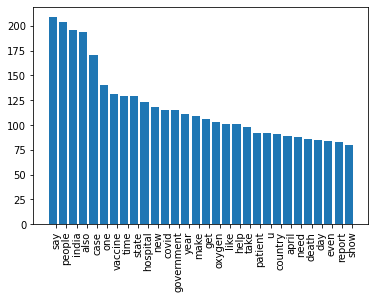

In [9]:
from collections import Counter
words_collection=' '.join(corpus).split()

counts = dict(Counter(words_collection).most_common(30))

labels, values = zip(*counts.items())

# Sorts  values in descending order
indSort = np.argsort(values)[::-1]

# Rearranges  data
labels = np.array(labels)[indSort]
values = np.array(values)[indSort]

indexes = np.arange(len(labels))

bar_width = 0.35

plt.bar(indexes,values)
plt.xticks(indexes + bar_width, labels)
plt.xticks(rotation = 90)
plt.show()





### Creating a dictionary and Bag of Words model

In [10]:
import gensim
from gensim import corpora
corpus_tokenized=[article.split() for article in corpus]
dictionary = corpora.Dictionary(corpus_tokenized)
print(dictionary)

Dictionary(6117 unique tokens: ['accept', 'align', 'best', 'change', 'continue']...)


In [12]:
bow_corpus = [dictionary.doc2bow(article) for article in corpus_tokenized]

### Next we create a Topic model using Latent Dirchlet Allocation, with gensim.


In [14]:
NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(bow_corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
topics = ldamodel.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.006*"say" + 0.006*"also" + 0.006*"people" + 0.004*"take" + 0.004*"season" + 0.004*"new" + 0.004*"evidence" + 0.004*"transmission" + 0.003*"like" + 0.003*"one"')
(1, '0.009*"india" + 0.008*"vaccine" + 0.007*"also" + 0.005*"one" + 0.005*"government" + 0.005*"people" + 0.004*"state" + 0.004*"say" + 0.004*"get" + 0.004*"even"')
(2, '0.009*"india" + 0.007*"say" + 0.006*"april" + 0.006*"help" + 0.006*"saffron" + 0.006*"people" + 0.005*"emailaddr" + 0.005*"also" + 0.005*"time" + 0.005*"oxygen"')
(3, '0.010*"case" + 0.008*"india" + 0.007*"new" + 0.006*"report" + 0.005*"also" + 0.004*"state" + 0.004*"total" + 0.004*"year" + 0.004*"time" + 0.004*"country"')
(4, '0.009*"say" + 0.009*"people" + 0.007*"hospital" + 0.006*"death" + 0.006*"patient" + 0.006*"case" + 0.006*"state" + 0.005*"oxygen" + 0.005*"also" + 0.005*"government"')


### Topics have a large number of Covid pandemic related words. This is quite natural as India was in the midst of the second wave of infections around that time.  To get an  optimal number of topics we compute Coherence Score for the corpus  using different number of topics. 

Text(0, 0.5, 'Coherence Score')

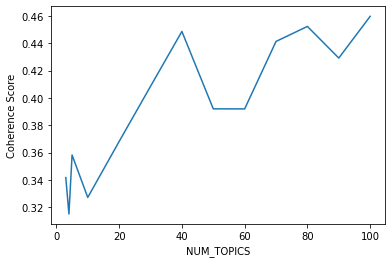

In [17]:
from gensim.models import CoherenceModel# Compute Coherence Score
list_for_plot=[]
#m=10
num_topics_set=[3,4,5,10,20,30,40,50,60,70,80,90,100]
for NUM_TOPICS in num_topics_set:
    ldamodel = gensim.models.ldamodel.LdaModel(bow_corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
    coherence_model_lda = CoherenceModel(model=ldamodel, texts=corpus_tokenized, dictionary=dictionary, coherence='c_v')
    list_for_plot.append([NUM_TOPICS,coherence_model_lda.get_coherence()])
list_for_plot=np.asarray(list_for_plot).reshape(len(num_topics_set),2)
plt.plot(list_for_plot[:,0],list_for_plot[:,1])
plt.xlabel("NUM_TOPICS")
plt.ylabel("Coherence Score")

### The coherence score  starts plateauing out somewhere after 40. Hence we choose num_topics=40. 

## Topic visualization and document classification according to dominant topic proportion


In [19]:
ldamodel = gensim.models.ldamodel.LdaModel(bow_corpus, num_topics = 40, id2word=dictionary, passes=15)

In [20]:
list_for_dataframe=[]
for i in range(len(bow_corpus)):
    list_for_dataframe.append(np.asarray(sorted(ldamodel[bow_corpus[i]],key=lambda x:x[1],reverse=True)[0]))

In [21]:
df = pd.DataFrame(list_for_dataframe, columns = ['Most Dominant Topic', 'Dominant Topic Proportion'])

In [22]:
df['Document Number'] = np.arange(len(df))

#### Following dataframe classifies documents in the corpus according to the topic with the highest topic proportion in the document.

In [25]:
df.sort_index(axis=1,inplace=True)
df.head(5)

,Document Number,Dominant Topic proportion,Most dominant topic
0,0,0.957601,15.0
1,1,0.686480,14.0
2,2,0.993412,12.0
3,3,0.989626,5.0
4,4,0.988661,32.0


### Next we count the number of documents which have similar most dominant topics. This will give us an idea of the most important topics for the corpus.

In [29]:
df.groupby('Most dominant topic').count().sort_values(by='Dominant Topic proportion',ascending=False)['Document Number'].head(5)

Most dominant topic
30.0    13
5.0     10
25.0     7
15.0     7
0.0      6
Name: Document Number, dtype: int64

###  Let us look at the word content of these topics in more details.

In [34]:
ldamodel.print_topic(30)

'0.032*"case" + 0.018*"death" + 0.016*"report" + 0.016*"state" + 0.015*"new" + 0.011*"total" + 0.011*"india" + 0.010*"number" + 0.009*"people" + 0.009*"hour"'

In [35]:
ldamodel.print_topic(5)

'0.012*"oxygen" + 0.008*"make" + 0.008*"also" + 0.008*"season" + 0.007*"story" + 0.007*"role" + 0.007*"show" + 0.006*"mahindra" + 0.006*"know" + 0.006*"people"'

In [36]:
ldamodel.print_topic(25)

'0.024*"vaccine" + 0.017*"india" + 0.014*"government" + 0.012*"say" + 0.010*"state" + 0.010*"supply" + 0.010*"delhi" + 0.010*"bed" + 0.008*"dose" + 0.008*"farmer"'

In [37]:
ldamodel.print_topic(15)

'0.018*"india" + 0.013*"emailaddr" + 0.009*"april" + 0.008*"people" + 0.008*"mg" + 0.007*"time" + 0.007*"help" + 0.007*"make" + 0.007*"well" + 0.006*"get"'

In [38]:
ldamodel.print_topic(0)

'0.013*"transmission" + 0.012*"evidence" + 0.011*"also" + 0.011*"mask" + 0.010*"vaccine" + 0.009*"variant" + 0.009*"sars" + 0.008*"infection" + 0.007*"researcher" + 0.007*"study"'

###  As is clear the dominant topics are covid infection related. We will visualize the topics next using PyLDAvis. 

In [40]:
from IPython.core.display import display, HTML
import pyLDAvis 
from pyLDAvis  import *
import pyLDAvis.gensim_models as gensimvis
%matplotlib inline
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(ldamodel, bow_corpus, dictionary=dictionary,sort_topics=False)
pyLDAvis.display(vis)

/home/rajarshi/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### The most important topics according to the number of documents in which they are most significant, as we saw previously, are topics 31,6,26,16,1(topics are numbered starting from 1 in pyLDAvis).  In pyLDAvis size of the topics is determined by their prevalence in the corpus. The important topics have larger circles associated as expected.

### While most of the topics are Covid infection related they may be representative of different aspects of it. The right panel showing important words according to their relevance to topics(defined in footnote 2)  is indicative of this. We can also check some documents in which the topics are most dominant for a better idea. 

In [73]:
# Extracting documents with topic number 30 as most dominant(31 in pyldavis visualisation)
df[df['Most dominant topic']==30].sort_values(by=['Dominant Topic proportion'],ascending=False).head(3)

/home/rajarshi/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Document Number,Dominant Topic proportion,Most dominant topic
114,114,0.996602,30.0
108,108,0.996388,30.0
124,124,0.996278,30.0


In [78]:
document[114]

/home/rajarshi/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'The second wave of novel coronavirus cases is taking a tighter grasp in India, with the number of infected cases reaching 1,32,05,926, with 1,45,384 cases surfacing in the last 24 hours.\n\nReuters\n\nHowever, data shared by the Union Health Ministry (highlighted in an NDTV report) has revealed that the second wave is affecting younger individuals and children. According to the data by the Union Health Ministry from March 1 to April 4, among the five worst-affected states in the nation, 79,688 cases have been of children.\n\n\n\nChildren cases across most affected states\n\nMaharashtra is the most affected state in terms of COVID-19 cases and the second wave made things a whole lot worse, especially for kids. Over 60,684 children were infected with SARS CoV-2 in Maharashtra in the aforementioned timeline. From this, 9,881 children are under the age of five years.\n\nChattisgarh comes second with 5,940 kids infected with the novel coronavirus, out of which 922 are below the age of 5.\n

In [64]:
# Extracting documents with topic number 2 as most dominant(3 in pyldavis visualisation)
df[df['Most dominant topic']==2].sort_values(by=['Dominant Topic proportion'],ascending=False).head(3)

/home/rajarshi/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Document Number,Dominant Topic proportion,Most dominant topic
75,75,0.996454,2.0
35,35,0.994895,2.0
105,105,0.993411,2.0


In [81]:
document[75]

/home/rajarshi/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'Thousands of migrant workers gathered at Anand Vihar ISBT here to catch a bus home, hours after Chief Minister Arvind Kejriwal announced a week-long lockdown and appealed to them with folded hands not to leave Delhi while sounding a word of assurance -- "Main hoon na" (I am here for you).\n\nPolice officials said over 5,000 people gathered at Anand Vihar including at ISBT as well as the railway station and the numbers were rising.\n\nEarlier in the day, Kejriwal appealed to the migrant workers to not leave Delhi, saying the short period of lockdown would need not be extended.\n\nThe Lallantop\n\n"I assure you, the government will take full care of you. Main hun na, mujh par bharosa rakho (I am here for you, have faith in me)," Kejriwal said, announcing the lockdown from 10 PM tonight to 5 AM next Monday.\n\nSudden announcement stirs panic\n\nA senior police officer said after the sudden announcement of the lockdown, thousands of migrant workers thronged the ISBT Anand Vihar area.\n\n"

### Topics 30 and 2(31 and 3 in pyldavis ) are well separated in the visualization. According to the relevant words, topic 30 seems to be more about the rising number of covid cases in the country. While, topic 2 seems to be more about how Covid is affecting or might affect different groups of people.  